## Import Libraries

In [98]:
import pandas as pd
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
#importear de preprocessing las normalizaciones
from sklearn.preprocessing import Normalizer
#dense transformer
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#random forest
from sklearn.ensemble import RandomForestRegressor

#svm 
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

def csv(predicciones,nombre,df_test):
    y_pred = pd.DataFrame({'id':df_test['id'],'Predicted':predicciones})
    y_pred['Predicted'] = y_pred['Predicted'].astype(int)
    y_pred.to_csv(nombre,index=False)




## Load Data

In [178]:
directorio = '../apau-smog-prediction/'
lista = os.listdir(directorio)
for i in lista:
    exec(i.split('.')[0] + ' = pd.read_csv(directorio + i)')

In [179]:
smog = train['Smog']
train = train.drop(['id','Comb (L/100 km)','Comb (mpg)','Model','Model Year','Smog'], axis=1)
id =test_nolabel['id']
test_nolabel = test_nolabel.drop(['id','Comb (L/100 km)','Comb (mpg)','Model','Model Year'], axis=1)

In [122]:
#quiero sacar split más optimo para un modelo, para ello 



(array([ 33.,   0., 125.,   0., 197.,   0., 112.,   0., 119.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <BarContainer object of 19 artists>)

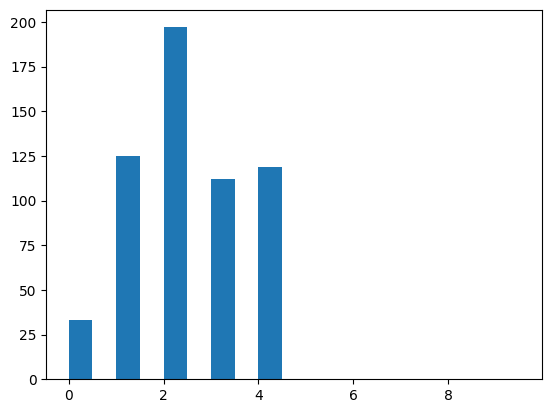

In [129]:
from matplotlib import pyplot as plt
from numpy import arange
#distribucion de y_train
plt.hist(smog, bins=arange(0, 10, 0.5))
#quiero que el train_test_split me de un conjunto de train con la misma distribucion o parecida

In [164]:
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])
norm_pipe = Pipeline([
    ("norm", Normalizer())
])

linear_pipe = Pipeline([
    ("linear", LinearSVC())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipe, cat_cols,),
    ("num", num_pipe, num_cols),
    ("norm", norm_pipe, num_cols),

])


In [139]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, smog, test_size=0.2, random_state=42)

In [145]:
# random forest regression
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=69))
    
])

#Bcross validation
from sklearn.model_selection import cross_val_predict
rf = RandomForestClassifier(n_estimators=100, random_state=69)
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(base_estimator=rf, n_estimators=10, random_state=69)
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: could not convert string to float: 'Porsche'

In [143]:
bag.fit(X_train, y_train)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [137]:
f1_score(y_train, y_pred, average='macro')

0.6395502890291678

In [114]:
#quiero hacer un grid search para ver si puedo mejorar el modelo
param_grid = {
    'rf__n_estimators': [100, 200, 300, 1000],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth' : [4,5,6,7,8],
    'rf__criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Vehicle '
                                                                          'Class',
                                                                          'Transmission',
                                                                          'Fuel '
                                                                          'Type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '...
                                                                                          Normalizer())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=69))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [4, 5, 6, 7, 8],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [115]:
grid_search.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 8,
 'rf__max_features': 'log2',
 'rf__n_estimators': 100}

In [116]:
#ahora que tengo los mejores parametros, voy a probar el modelo con ellos
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=69, max_depth=8, max_features='log2', criterion='entropy'))
])

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [131]:
f1_score(y_test, y_pred, average='macro')

0.7859236889646701

In [238]:
# svm
svm = Pipeline([
    ("preprocessor", preprocessor),
    ("svm", SVC())
])
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

svm.fit(X_resampled, y_resampled).score(X_test, y_test)

svm.fit(X_train, y_train).score(X_test, y_test)


0.7457627118644068

In [106]:
f1_score(y_test, y_pred, average='macro')

0.775311184364853

In [107]:
#kkN
from sklearn.neighbors import KNeighborsClassifier
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])

knn.fit(X_train, y_train).score(X_test, y_test)





0.7288135593220338

In [111]:
## random forest regression
rfr = Pipeline([
    ("preprocessor", preprocessor),
    ("rfr", RandomForestRegressor(n_estimators=100, random_state=69))
])

rfr.fit(X_train, y_train).score(X_test, y_test)


0.5305976629284697

In [235]:
#quiero combinar todos los knn, svm y random forest para ello voy a hacer un voting classifier o un stacking classifier
from sklearn.ensemble import StackingClassifier

rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier())
])
rf1 = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=69))
])

rf2 = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=69))
])

rf3 = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=1000, random_state=69,))
])



estimators = [
    ('rf', rf),
    ('svm', svm),
    
]

#que estimador debemosusar para el final estimator? 
#modelo probabilisttico
from sklearn.linear_model import LogisticRegression

#multinominal
from sklearn.naive_bayes import MultinomialNB
#voting classifier
from sklearn.ensemble import VotingClassifier

#clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf = VotingClassifier(estimators=estimators, voting='soft') # soft

#stacking classifier hace un voting classifier con los modelos que le pasas, y el final estimator es el que hace el voto final, el estimador final

#tengo un problema mi dataset de entrenamiento tiene debalanceo de smog, es decir, hay muchos 2 y pocos 0,1,3 y4
#quiero hacer un oversampling para que el modelo no se quede con el 2, y pueda aprender de los demas
#oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(train, smog)



In [234]:
clf.fit(X_resampled, y_resampled)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [204]:
#GRID SEARCH PARA STACKING CLASSIFIER
from sklearn.model_selection import GridSearchCV

param_grid = {
    

In [225]:
y_pred = clf.predict(train)

In [226]:
f1_score(smog, y_pred, average='macro')

0.9956461593752268

In [228]:
#confusion matrix
confusion_matrix(smog, y_pred)

array([[ 33,   0,   0,   0,   0],
       [  0, 123,   1,   0,   1],
       [  0,   0, 196,   1,   0],
       [  0,   0,   0, 112,   0],
       [  0,   0,   0,   0, 119]], dtype=int64)

In [229]:
predicciones = clf.predict(test_nolabel)

In [180]:
test_nolabel['id'] = id

In [230]:
csv(predicciones,'rf_svm__knn_logreg_todo.csv',test_nolabel)

In [159]:
#confusion matrix
confusion_matrix(smog, y_pred)

array([[ 31,   2,   0,   0,   0],
       [  6,  81,  22,   2,  14],
       [  7,  17, 158,   9,   6],
       [  0,   0,  12,  98,   2],
       [  0,   8,  12,   5,  94]], dtype=int64)

In [16]:
predicciones = rf.predict(test_nolabel)

KeyError: "['Smog'] not in index"